In [1]:
import pandas
import numpy
from matplotlib import pyplot
import os
import ROOT

Welcome to JupyROOT 6.24/06


In [2]:
times = {"taskid":[],"mean":[],"meanerr":[],"throughput_MB_s":[]}
maindir = "20211115-16corespernode-taskset015-200x"
timedirs = [timedir for timedir in os.listdir(maindir) if timedir.startswith("timeresults")]

dfs = []
for timedir in timedirs:
    nodes = int(timedir.split("_")[2].replace("nodes",""))
    corespernode = int(timedir.split("_")[3].replace("corespernode",""))
    chunks = nodes*corespernode
    for f in os.listdir(os.path.join(maindir, timedir)):
        df = pandas.read_csv(os.path.join(maindir, timedir, f), header=None, names=["taskruntime","taskreadtime","readthroughput","readpayload"], skiprows=1)
        taskid = int(f.split("_")[1].replace("task",""))
        df["taskid"] = int(taskid)
        df["nodes"] = int(nodes)
        df["chunks"] = int(chunks)
        dfs.append(df)

df = pandas.concat(dfs).sort_values(by="nodes").reset_index(drop=True)
df

,taskruntime,taskreadtime,readthroughput,readpayload,taskid,nodes,chunks
0,57.575,56782791763,248,14117594700,12,1,16
1,54.612,53996367730,261,14117594700,7,1,16
2,50.179,49218534297,286,14117594700,7,1,16
3,55.245,54537450945,258,14117594700,7,1,16
4,55.578,54869512241,257,14117594700,7,1,16
...,...,...,...,...,...,...,...
3019,11.159,10589950495,222,2352932472,54,6,96
3020,11.059,10528519800,223,2352932472,54,6,96
3021,10.271,9680507975,243,2352932472,54,6,96
3022,10.544,9938675477,236,2352932472,85,6,96


In [3]:
meantaskthroughput = df.groupby(["chunks"]).mean()
meantaskthroughput = meantaskthroughput.reset_index().sort_values("chunks").reset_index(drop=True)
meantaskthroughput


,chunks,taskruntime,taskreadtime,readthroughput,readpayload,taskid,nodes
0,16,53.694708,5.281492e+10,267.402778,1.411759e+10,7.5,1.0
1,32,29.515906,2.897465e+10,243.569444,7.058797e+09,15.5,2.0
2,48,20.513044,2.003070e+10,234.756944,4.705865e+09,23.5,3.0
3,64,15.540026,1.504754e+10,234.626736,3.529399e+09,31.5,4.0
4,80,12.280254,1.175424e+10,240.337500,2.823519e+09,39.5,5.0
5,96,10.687969,1.013204e+10,232.807870,2.352932e+09,47.5,6.0


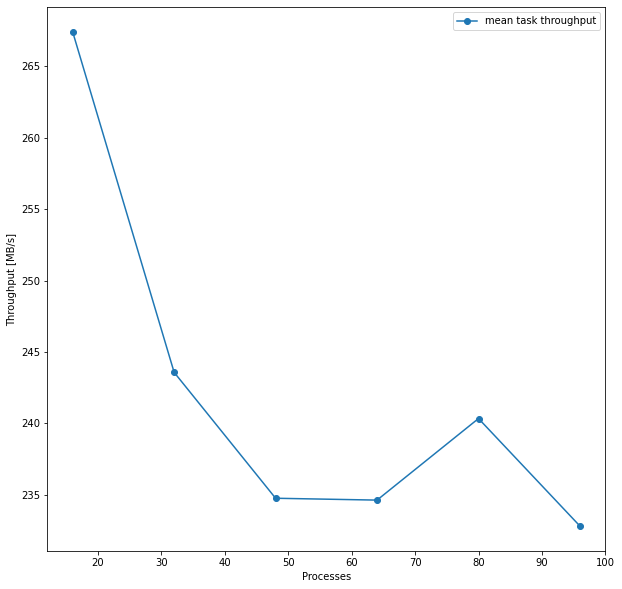

In [4]:
pyplot.figure(figsize=[10,10])
pyplot.plot(meantaskthroughput["chunks"], meantaskthroughput["readthroughput"], label="mean task throughput", marker="o")
pyplot.xlabel("Processes")
pyplot.ylabel("Throughput [MB/s]")
pyplot.legend()

In [5]:
sumthroughput = df.groupby(["chunks","nodes","taskid"]).mean()
sumthroughput = sumthroughput.reset_index().groupby(["chunks","nodes"]).sum()
sumthroughput = sumthroughput.reset_index()
sumthroughput["totalthroughput"] = sumthroughput["readthroughput"] / 1024
sumthroughput["speedup"] = sumthroughput["readthroughput"] / sumthroughput["readthroughput"][0] 
sumthroughput

,chunks,nodes,taskid,taskruntime,taskreadtime,readthroughput,readpayload,totalthroughput,speedup
0,16,1,120,859.115333,8.450387e+11,4278.444444,2.258815e+11,4.178168,1.000000
1,32,2,496,944.509000,9.271889e+11,7794.222222,2.258815e+11,7.611545,1.821742
2,48,3,1128,984.626111,9.614734e+11,11268.333333,2.258815e+11,11.004232,2.633745
3,64,4,2016,994.561667,9.630427e+11,15016.111111,2.258815e+11,14.664171,3.509713
4,80,5,3160,982.420333,9.403390e+11,19227.000000,2.258815e+11,18.776367,4.493923
5,96,6,4560,1026.045000,9.726763e+11,22349.555556,2.258815e+11,21.825738,5.223757


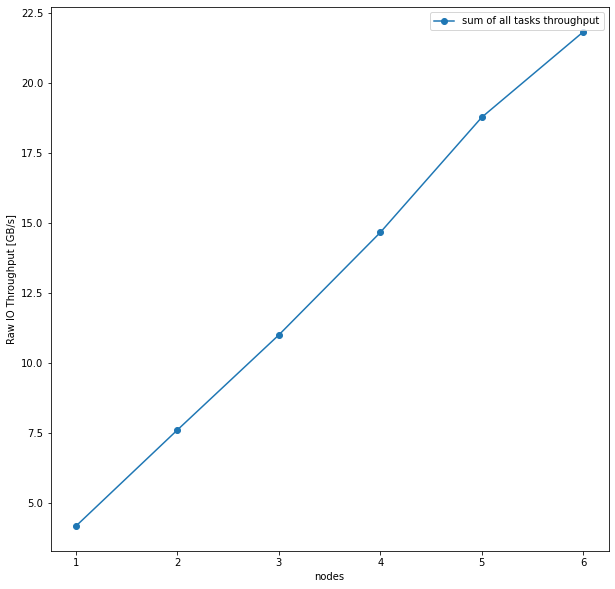

In [7]:
pyplot.figure(figsize=[10,10])
pyplot.plot(sumthroughput["nodes"], sumthroughput["totalthroughput"], label="sum of all tasks throughput", marker="o")
pyplot.xlabel("nodes")
pyplot.ylabel("Raw IO Throughput [GB/s]")
pyplot.legend()

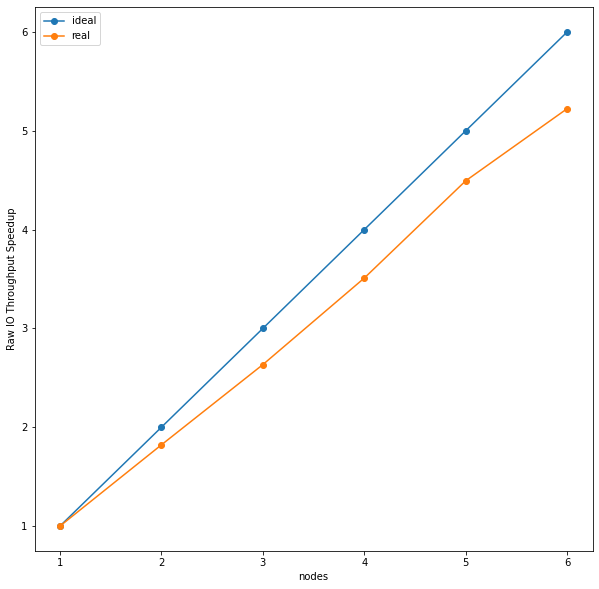

In [8]:
pyplot.figure(figsize=[10,10])
pyplot.plot(sumthroughput["nodes"], sumthroughput["nodes"], label="ideal", marker="o")
pyplot.plot(sumthroughput["nodes"], sumthroughput["speedup"], label="real", marker="o")
pyplot.xlabel("nodes")
pyplot.ylabel("Raw IO Throughput Speedup")
pyplot.legend()

# Python timer

In [9]:
times = {"nodes":[],"meanruntime":[], "err":[], "throughput_MB_s":[]}
timedir = "20211115-16corespernode-taskset015-200x/appruntimes"
datasetsize = 157400503680
readpercent = 0.7949011466389114
readsize = 225881515200 # taken from the RNTuple metrics above

for f in os.listdir(timedir):
    array = numpy.genfromtxt(os.path.join(timedir, f), skip_header=2)
    nodes = f.split("_")[5].replace("nodes","")
    time_mean = numpy.mean(array)
    times["nodes"].append(int(nodes))
    times["meanruntime"].append(round(time_mean, 2))
    times["err"].append(round(numpy.std(array)/numpy.sqrt(len(array)), 2))
    times["throughput_MB_s"].append(round(readsize/time_mean/1024/1024))
    
timesdf = pandas.DataFrame(times)
timesdf = timesdf.sort_values(by="nodes").reset_index(drop=True).copy()
throughput_1node = timesdf["throughput_MB_s"][0]
time_1node = timesdf["meanruntime"][0]
timesdf["runtimespeedup"] = time_1node / timesdf["meanruntime"]
timesdf["throughputspeedup"] = timesdf["throughput_MB_s"] / throughput_1node
timesdf

,nodes,meanruntime,err,throughput_MB_s,runtimespeedup,throughputspeedup
0,1,54.12,0.79,3980,1.000000,1.000000
1,2,30.47,0.45,7069,1.776173,1.776131
2,3,21.44,0.20,10048,2.524254,2.524623
3,4,16.36,0.26,13170,3.308068,3.309045
4,5,12.90,0.22,16695,4.195349,4.194724
5,6,11.68,0.42,18441,4.633562,4.633417


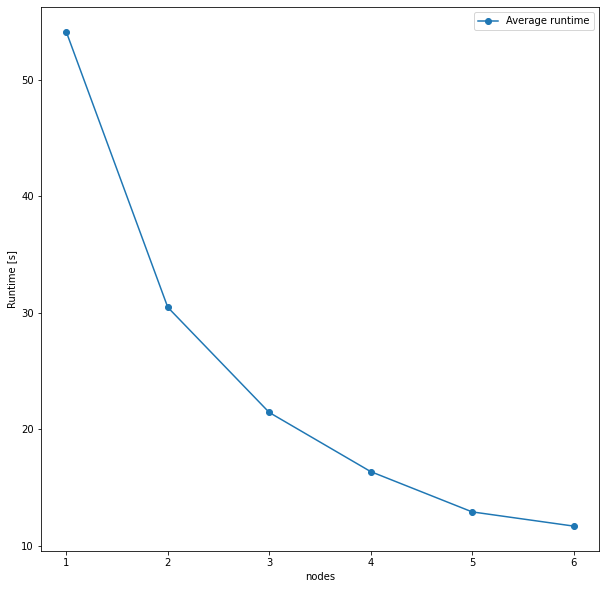

In [10]:
pyplot.figure(figsize=[10,10])
pyplot.plot(timesdf["nodes"], timesdf["meanruntime"], label="Average runtime", marker="o")
pyplot.xlabel("nodes")
pyplot.ylabel("Runtime [s]")
pyplot.legend()

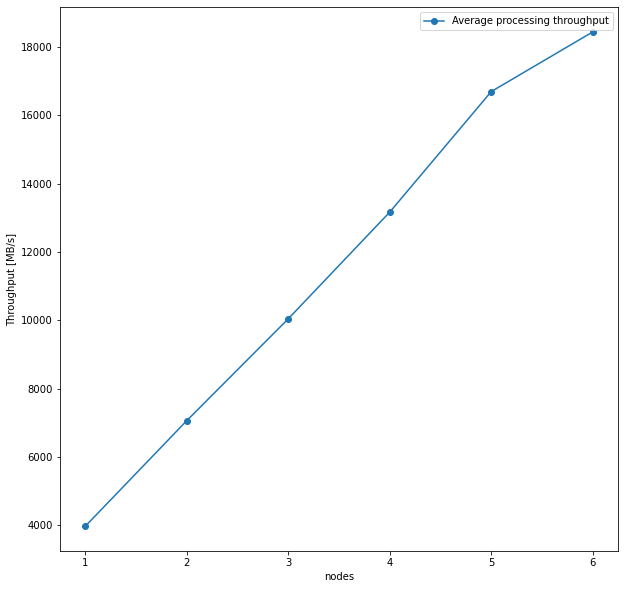

In [11]:
pyplot.figure(figsize=[10,10])
pyplot.plot(timesdf["nodes"], timesdf["throughput_MB_s"], label="Average processing throughput", marker="o")
pyplot.xlabel("nodes")
pyplot.ylabel("Throughput [MB/s]")
pyplot.legend()

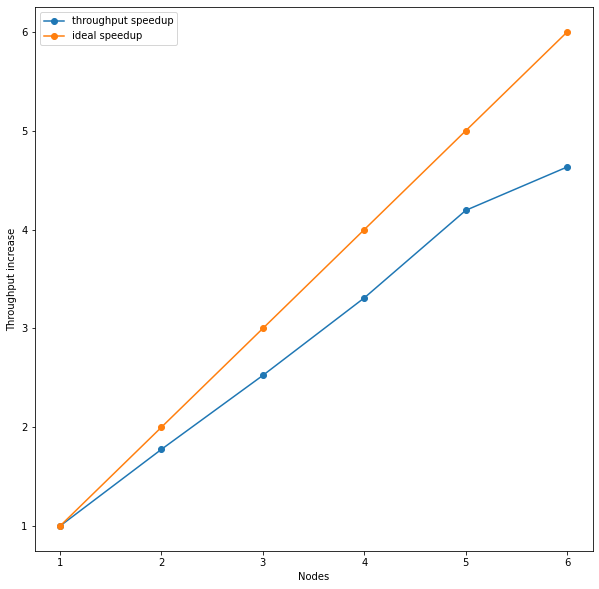

In [12]:
pyplot.figure(figsize=[10,10])
pyplot.plot(timesdf["nodes"], timesdf["throughputspeedup"], label="throughput speedup", marker="o")
pyplot.plot(timesdf["nodes"], timesdf["nodes"], label="ideal speedup", marker="o")
pyplot.xticks(timesdf["nodes"])
pyplot.yticks(timesdf["nodes"])
pyplot.xlabel("Nodes")
pyplot.ylabel("Throughput increase")
pyplot.legend()